In [44]:
import os
import torch
import mae.models_mae
from mae.models_mae import MaskedAutoencoderViT
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from pathlib import Path

In [2]:
print(os.getcwd())

/workspace/gfm-gap-filling/pretraining


In [3]:
from mae_training import CombinedDataset

In [4]:
local_rank = 1
mean = torch.tensor([495.7316,  814.1386,  924.5740, 2962.5623, 2640.8833, 1740.3031])[None,:,None,None,None].to(local_rank)
std = torch.tensor([286.9569, 359.3304, 576.3471, 892.2656, 945.9432, 916.1625])[None,:,None,None,None].to(local_rank)


In [5]:
 def prepare_model(checkpoint, arch='mae_vit_base_patch16'):
        # build model
        model = getattr(mae.models_mae, arch)()
        # load model
        checkpoint_file = torch.load(checkpoint, map_location=f'cuda:{local_rank}')
        msg = model.load_state_dict(checkpoint_file, strict=False)
        print(msg)
        return model

In [96]:
checkpoint = Path("/workspace/gfm-gap-filling/pretraining/epoch-832-loss-0.0473.pt")
save_dir = Path("/workspace/data/lchu/hls/vis/zero_shot_visualization")

In [97]:
model = prepare_model(checkpoint, 'mae_vit_base_patch16')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


In [98]:
val_dataset = CombinedDataset("/workspace/gfm-gap-filling/pretraining/train_single_band/train_single_band", split="validate", num_frames=3, img_size=224, bands=6, cloud_range=[0.01,1.0],
                              # random_cropping=random_cropping, remove_cloud=True, 
                               normalize=True)

In [99]:
print(f"--> Validation set len = {len(val_dataset)}")
print(f"--> Validation set masks = {val_dataset.n_cloudpaths}")

--> Validation set len = 1621
--> Validation set masks = 1600


In [100]:
torch.cuda.set_device(local_rank)
model = model.to(torch.cuda.current_device())

In [108]:
first_batch = torch.from_numpy(val_dataset[640][np.newaxis, ...]).to(local_rank)
print("Shape of the first item:", first_batch.shape)

Shape of the first item: torch.Size([1, 2, 6, 3, 224, 224])


In [109]:
label_mask_batch = first_batch[:,1,:,:,:,:].to(local_rank)
batch = first_batch[:,0,:,:,:,:].to(local_rank)
loss, pred, mask = model(batch, label_mask_batch, 0.75)

In [110]:
input = torch.ceil((batch.detach() * std) + mean) * 0.0001
input_mask = label_mask_batch.detach()
predicted = torch.ceil(model.unpatchify(pred).detach() * std + mean) * 0.0001
input_masked = input * input_mask
predicted_masked = predicted * input_mask
non_cloud = input * (1-input_mask)

In [111]:
torch.min(batch)

tensor(-3.0972, device='cuda:1')

In [112]:
torch.min(non_cloud)

tensor(0., device='cuda:1')

In [113]:
B4_non_cloud = non_cloud[0,3,1,:,:].cpu().numpy()
B5_non_cloud = non_cloud[0,4,1,:,:].cpu().numpy()
B4_true = input_masked[0,3,1,:,:].cpu().numpy()
B5_true = input_masked[0,4,1,:,:].cpu().numpy()
B4_gen = predicted_masked[0,3,1,:,:].cpu().numpy()
B5_gen = predicted_masked[0,4,1,:,:].cpu().numpy()
B4_non_cloud[B4_non_cloud == 0] = np.nan
B5_non_cloud[B5_non_cloud == 0] = np.nan
B4_gen[B4_gen == 0] = np.nan
B5_gen[B5_gen == 0] = np.nan
B4_true[B4_true == 0] = np.nan
B5_true[B5_true == 0] = np.nan

/workspace/data/lchu/hls/vis/zero_shot_visualization/B4_B5_Graph.png


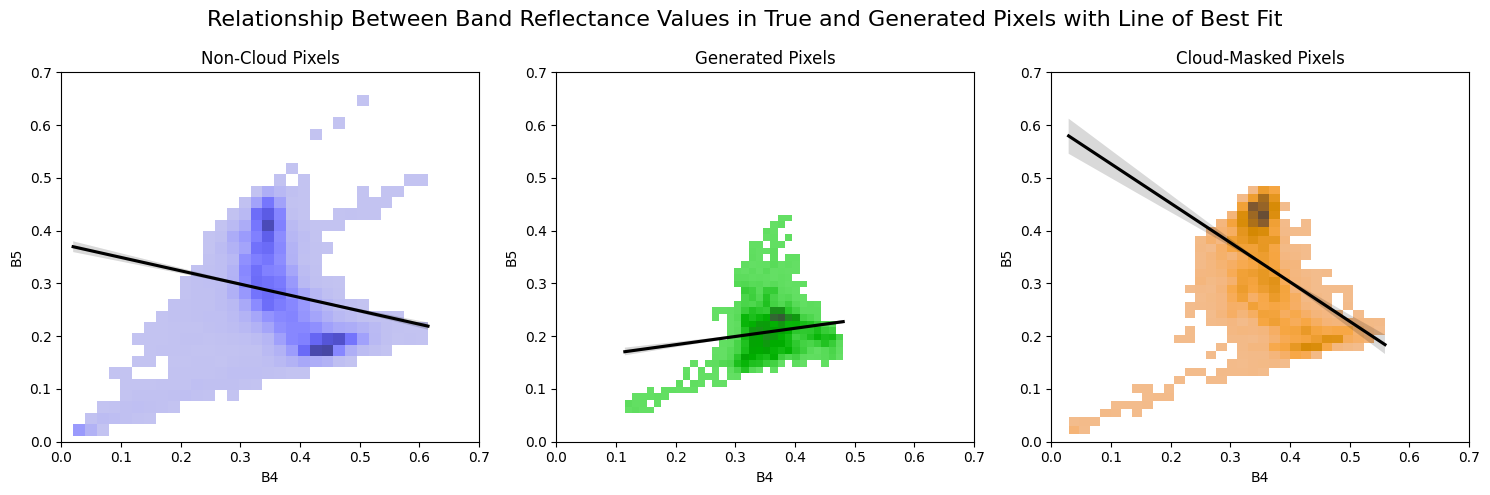

In [114]:
non_cloud_data = pd.DataFrame({
    'B4': B4_non_cloud.flatten(),
    'B5': B5_non_cloud.flatten(),
    'type': 'non_cloud'
})
gen_data = pd.DataFrame({
    'B4': B4_gen.flatten(),
    'B5': B5_gen.flatten(),
    'type': 'gen'
})
true_data = pd.DataFrame({
    'B4': B4_true.flatten(),
    'B5': B5_true.flatten(),
    'type': 'true'
})


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(non_cloud_data, x="B4", y="B5", bins=30, ax=axes[0], color='blue')
axes[0].set_xlim(0, 0.7)
axes[0].set_ylim(0, 0.7)
axes[0].set_xlabel('Red Reflectance')
axes[0].set_ylabel('NIR Reflectance')
axes[0].set_title('Non-Cloud Pixels')
sns.regplot(non_cloud_data, x="B4", y="B5", ax=axes[0], scatter=False, color='black')

sns.histplot(gen_data, x="B4", y="B5", bins=30, ax=axes[1], color='green')
axes[1].set_xlim(0, 0.7)
axes[1].set_ylim(0, 0.7)
axes[1].set_xlabel('Red Reflectance')
axes[1].set_ylabel('NIR Reflectance')
axes[1].set_title('Generated Pixels')
sns.regplot(gen_data, x="B4", y="B5", ax=axes[1], scatter=False, color='black')

sns.histplot(true_data, x="B4", y="B5", bins=30, ax=axes[2], color='orange')
axes[2].set_xlim(0, 0.7)
axes[2].set_ylim(0, 0.7)
axes[2].set_xlabel('Red Reflectance')
axes[2].set_ylabel('NIR Reflectance')
axes[2].set_title('Cloud-Masked Pixels')
sns.regplot(true_data, x="B4", y="B5", ax=axes[2], scatter=False, color='black')

# Set a common title for all subplots
plt.suptitle(f'Relationship Between Band Reflectance Values in True and Generated Pixels with Line of Best Fit', fontsize=16)

# Adjust layout for better spacing between subplots
plt.tight_layout()
filename = 'B4_B5_Graph.png'
print(str(save_dir / filename))
plt.savefig(save_dir / filename, format='png')
